In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from torchvision.datasets import EMNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np

In [4]:
# Загрузка EMNIST (подмножество Letters)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # 28x28 -> 784
])

dataset = EMNIST(root="./data", split="letters", train=True, download=True, transform=transform)
loader = DataLoader(dataset, batch_size=10000, shuffle=True)

# Получим подмножество данных
images, labels = next(iter(loader))
X = images.numpy()
y = labels.numpy()

In [5]:
class SOM:
    def __init__(self, x_size, y_size, input_dim, lr=0.5, radius=None, decay=0.99):
        self.x_size = x_size
        self.y_size = y_size
        self.input_dim = input_dim
        self.lr = lr
        self.radius = radius if radius else max(x_size, y_size) / 2
        self.decay = decay

        # Инициализация весов
        self.weights = np.random.rand(x_size, y_size, input_dim)
        self.locations = np.array([[i, j] for i in range(x_size) for j in range(y_size)])

    def find_bmu(self, sample):
        # Вычисление расстояний до всех нейронов
        dists = np.linalg.norm(self.weights - sample, axis=2)
        return np.unravel_index(np.argmin(dists), (self.x_size, self.y_size))

    def train(self, data, num_epochs=10):
        for epoch in range(num_epochs):
            for sample in data:
                bmu_idx = self.find_bmu(sample)
                self.update_weights(sample, bmu_idx)

            self.lr *= self.decay
            self.radius *= self.decay
            print(f"Epoch {epoch+1}/{num_epochs} done.")

    def update_weights(self, sample, bmu_idx):
        for i in range(self.x_size):
            for j in range(self.y_size):
                dist = np.linalg.norm(np.array([i, j]) - np.array(bmu_idx))
                if dist <= self.radius:
                    influence = np.exp(-(dist**2) / (2 * (self.radius**2)))
                    self.weights[i, j] += self.lr * influence * (sample - self.weights[i, j])

    def map_labels(self, data, labels):
        label_map = {}
        for i in range(len(data)):
            bmu = self.find_bmu(data[i])
            key = tuple(bmu)
            if key in label_map:
                label_map[key].append(labels[i])
            else:
                label_map[key] = [labels[i]]
        # Получаем наиболее частую метку для каждого нейрона
        for key in label_map:
            label_map[key] = np.bincount(label_map[key]).argmax()
        return label_map

Epoch 1/10 done.
Epoch 2/10 done.
Epoch 3/10 done.
Epoch 4/10 done.
Epoch 5/10 done.
Epoch 6/10 done.
Epoch 7/10 done.
Epoch 8/10 done.
Epoch 9/10 done.
Epoch 10/10 done.


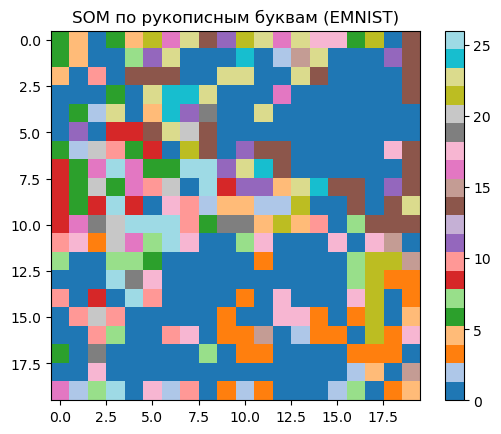

In [6]:
som = SOM(20, 20, 784, lr=0.5)
som.train(X[:5000], num_epochs=10)  # обучим на 5000 примерах

label_map = som.map_labels(X[:5000], y[:5000])

grid = np.zeros((20, 20))
for (i, j), label in label_map.items():
    grid[i, j] = label

plt.imshow(grid, cmap='tab20')
plt.colorbar()
plt.title("SOM по рукописным буквам (EMNIST)")
plt.show()

In [7]:
def predict(som, sample, label_map):
    bmu = som.find_bmu(sample)
    return label_map.get(tuple(bmu), -1)  # -1 — если для этого нейрона нет метки

In [8]:
sample = X[5005]  # новое изображение
true_label = y[5005]
predicted = predict(som, sample, label_map)

print(f"Истинная метка: {true_label}, Предсказание: {predicted}")

Истинная метка: 3, Предсказание: 15


In [9]:
from sklearn.metrics import accuracy_score

y_true = y[5001:6000]
y_pred = [predict(som, sample, label_map) for sample in X[5001:6000]]

acc = accuracy_score(y_true, y_pred)
print(f"Точность SOM на тестовом наборе: {acc:.3f}")

Точность SOM на тестовом наборе: 0.241


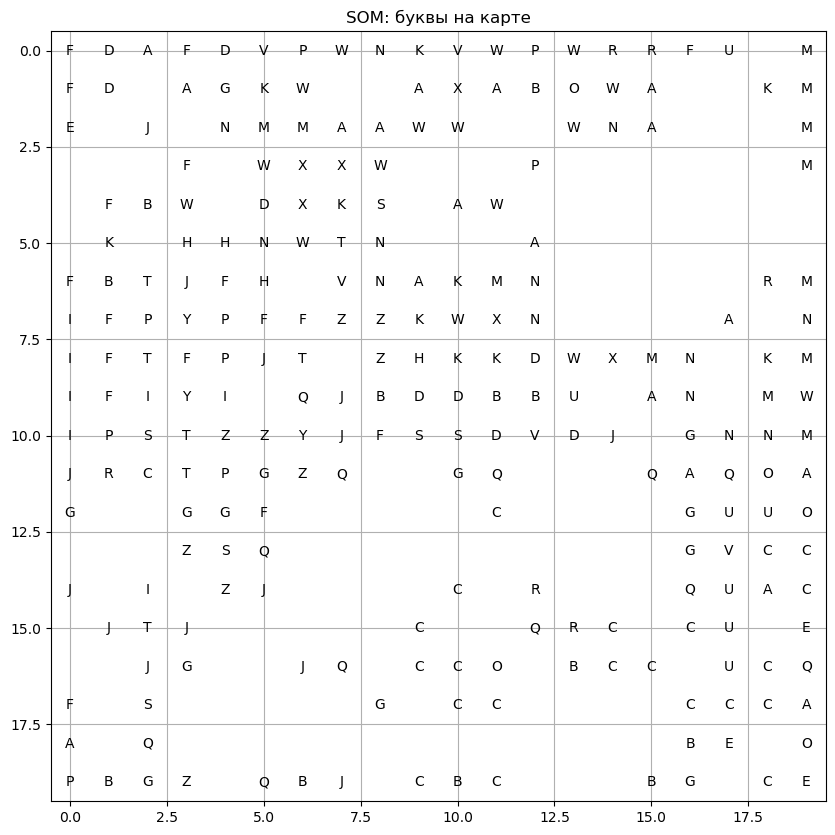

In [10]:
plt.figure(figsize=(10, 10))
for (i, j), label in label_map.items():
    plt.text(j, i, chr(label + 64), ha='center', va='center')  # 'A' = 65
plt.xlim(-0.5, 19.5)
plt.ylim(-0.5, 19.5)
plt.gca().invert_yaxis()
plt.grid(True)
plt.title("SOM: буквы на карте")
plt.show()

In [18]:
# Обозначения для букв C, I, X в EMNIST Letters (метки от 1 до 26, A = 1)
label_map_ascii = {3: 'C', 9: 'I', 24: 'X', 15: 'O'}
target_labels = [3, 9, 24, 15]

# Фильтруем данные
mask = np.isin(y, target_labels)
X_sub = X[mask]
y_sub = y[mask]

In [19]:
som = SOM(x_size=15, y_size=15, input_dim=784, lr=0.5, decay=0.95)
som.train(X_sub, num_epochs=30)
label_map_sub = som.map_labels(X_sub, y_sub)

Epoch 1/30 done.
Epoch 2/30 done.
Epoch 3/30 done.
Epoch 4/30 done.
Epoch 5/30 done.
Epoch 6/30 done.
Epoch 7/30 done.
Epoch 8/30 done.
Epoch 9/30 done.
Epoch 10/30 done.
Epoch 11/30 done.
Epoch 12/30 done.
Epoch 13/30 done.
Epoch 14/30 done.
Epoch 15/30 done.
Epoch 16/30 done.
Epoch 17/30 done.
Epoch 18/30 done.
Epoch 19/30 done.
Epoch 20/30 done.
Epoch 21/30 done.
Epoch 22/30 done.
Epoch 23/30 done.
Epoch 24/30 done.
Epoch 25/30 done.
Epoch 26/30 done.
Epoch 27/30 done.
Epoch 28/30 done.
Epoch 29/30 done.
Epoch 30/30 done.


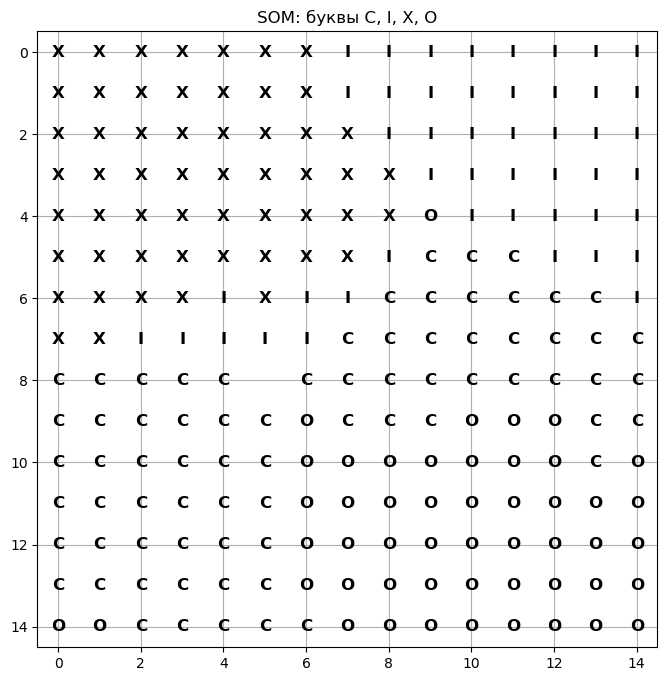

In [21]:
plt.figure(figsize=(8, 8))
for (i, j), label in label_map_sub.items():
    char = label_map_ascii.get(label, '?')
    plt.text(j, i, char, ha='center', va='center', fontsize=12, fontweight='bold')
plt.title("SOM: буквы C, I, X, O")
plt.xlim(-0.5, som.x_size - 0.5)
plt.ylim(-0.5, som.y_size - 0.5)
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()

In [22]:
y_pred = [predict(som, sample, label_map_sub) for sample in X_sub]
acc = np.mean(np.array(y_pred) == y_sub)
print(f"Точность на подмножестве C/I/X/O: {acc:.3f}")

Точность на подмножестве C/I/X/O: 0.946
